In [2]:
import qutip as qt
import numpy as np
import matplotlib.pyplot as plt
import sys
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import bisect
import matplotlib.colors as mcolors
print(qt.__version__)
from scipy.stats import ks_2samp

5.0.4


In [3]:
def create_random_state(n):
        basis_states = [qt.basis([2]*n, [int(i) for i in format(j, f'0{n}b')]) for j in range(2**n)]
        uniform_values = np.random.uniform(0, 1, 2**n)
        coefficients = uniform_values / np.sqrt(np.sum(uniform_values**2))
    
        random_state = sum(coeff * basis for coeff, basis in zip(coefficients, basis_states))
        return random_state

def create_random_state_haar(n):
    dim = 2**n
    
    # Complex coefficients: real and imaginary parts from normal distribution
    real_parts = np.random.normal(0, 1, dim)
    imag_parts = np.random.normal(0, 1, dim)
    complex_coeffs = real_parts + 1j * imag_parts

    # Normalize the vector
    normalized_coeffs = complex_coeffs / np.linalg.norm(complex_coeffs)

    # Create basis states
    basis_states = [qt.basis([2]*n, [int(i) for i in format(j, f'0{n}b')]) for j in range(dim)]

    # Combine into a state
    random_state = sum(coeff * basis for coeff, basis in zip(normalized_coeffs, basis_states))
    
    return random_state

def find_k(p):
    return -int(-1/p)

def compute_density_matrix(state):
        return state * state.dag()

def state_0(n):
    return qt.tensor([qt.basis(2, 0) for _ in range(n)])

def state_1(n):
    return qt.tensor([qt.basis(2, 1) for _ in range(n)])

def compute_density_matrix(state):
    return state * state.dag()

def compute_reduced_density_matrices_3(p):
    p_A = p.ptrace([0])  # Tracing out B and C
    p_B = p.ptrace([1])  # Tracing out A and C
    p_C = p.ptrace([2])  # Tracing out A and B
    p_AB = p.ptrace([0, 1])  # Tracing out C
    p_AC = p.ptrace([0, 2])  # Tracing out B
    p_BC = p.ptrace([1, 2])  # Tracing out A
    return p_A, p_B, p_C, p_AB, p_AC, p_BC

def compute_reduced_density_matrices_7(p):
    p_A = p.ptrace([0,1,2])  # Tracing out B and C
    p_B = p.ptrace([4,5,6])  # Tracing out A and C
    p_C = p.ptrace([3])  # Tracing out A and B
    p_AB = p.ptrace([0,1,2,4,5,6])  # Tracing out C
    p_AC = p.ptrace([0,1,2,3])  # Tracing out B
    p_BC = p.ptrace([3,4,5,6])  # Tracing out A
    return p_A, p_B, p_C, p_AB, p_AC, p_BC

def compute_ratio_per_bin(A, B, n):
    A = np.array(A)
    B = np.array(B)
    bins = np.linspace(0, 1, n + 1)

    counts_A, _ = np.histogram(A, bins=bins)
    counts_B, _ = np.histogram(B, bins=bins)

    # Ratio per bin, avoid division by zero
    with np.errstate(divide='ignore', invalid='ignore'):
        M = np.where(counts_B != 0, (counts_B / counts_A) * 100, 0)

    return M

def sample_single_p_with_uniform_entropy():
    def H(p):
        p = np.clip(p, 1e-10, 1 - 1e-10)
        return -p * np.log2(p) - (1 - p) * np.log2(1 - p)

    def invert_entropy(h, side):
        return bisect(lambda p: H(p) - h, 1e-10 if side == 'lower' else 0.5, 
                                     0.5 if side == 'lower' else 1 - 1e-10)

    h = np.random.uniform(0, 1)
    side = np.random.choice(['lower', 'upper'])
    return invert_entropy(h, side)

def shannon_entropy(probs):
    probs = np.array(probs)
    #probs = probs[probs > 0]  # Remove zero probabilities to avoid log(0)
    probs = np.clip(probs, 1e-10, 1)
    return -np.sum(probs * np.log2(probs))

def quantum_relative_entropy(rho, sigma):
    log_rho = (rho.logm())
    log_sigma = (sigma.logm())
    return (rho * (log_rho - log_sigma)).tr().real
def conditional_entropy(rho,sigma):
     return qt.entropy_vn(rho, base = 2) - qt.entropy_vn(sigma, base = 2)



def compare_histograms(A, B, bins=30):
    """
    Generates comparative histograms and computes a similarity measure.

    Parameters:
    - A, B: Arrays to compare.
    - bins: Number of histogram bins (default=30).

    Returns:
    - ks_stat: Kolmogorov-Smirnov statistic.
    - p_value: p-value indicating similarity (higher = more similar).
    """

    # Plot histograms
    plt.figure(figsize=(10, 6))
    plt.hist(A, bins=bins, alpha=0.5, label='Array A', density=True)
    plt.hist(B, bins=bins, alpha=0.5, label='Array B', density=True)
    plt.legend()
    plt.title('Comparative Histogram')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.grid(True)
    plt.show()

    # Perform Kolmogorov-Smirnov test
    ks_stat, p_value = ks_2samp(A, B)
    print(f"Kolmogorov-Smirnov Test:\nStatistic = {ks_stat:.4f}, p-value = {p_value:.4f}")

    return ks_stat, p_value



In [4]:
import itertools

# Define Pauli operators
paulis = [qt.qeye(2), qt.sigmax(), qt.sigmay(), qt.sigmaz()]
pauli_labels = ['I', 'X', 'Y', 'Z']  # Optional, for clarity

# Initialize V
V_A = 0

# Construct the operator
for i, A in enumerate(paulis):
    for j, B in enumerate(paulis):
        term = qt.tensor(A, B, A, B)
        V_A += term

# Normalize
V_A = V_A / 4
V_norm = np.max(np.abs(V_A.eigenenergies()))

# 2D AB

In [42]:
n = 10000
num_qubits = 3

Z = qt.sigmaz() 
X = qt.sigmax() 
Y = qt.sigmay() 
I_2 = qt.qeye(2)

V = (1/2)*(qt.tensor(Z, Z) + qt.tensor(X, X) + qt.tensor(Y, Y) + qt.tensor(I_2, I_2))
V_2 = (1/2)*(qt.tensor(Z, Z, Z, Z) + qt.tensor(X, X,X,X) + qt.tensor(Y, Y,Y,Y) + qt.tensor(I_2, I_2, I_2,I_2))
V_base_norm = np.max(np.abs(V_A.eigenenergies()))
Z_2 = qt.tensor(Z, Z)
Z_full = qt.tensor(Z, Z, Z)
Z_norm =  np.max(np.abs(Z.eigenenergies()))


B_gir_1 = np.zeros(n)
B_gir_2 = np.zeros(n)
purity_AB = np.zeros(n)
I = np.zeros(n)

k = 0

for i in range(1,n):
    random_state_1 = create_random_state(num_qubits)
    random_state_2 = create_random_state(num_qubits)

    p_random_1 = compute_density_matrix(random_state_1)
    p_random_2 = compute_density_matrix(random_state_2)
    u = np.random.uniform(0, 1)
    P_1, P_2= np.random.dirichlet([0.1, 0.1])
    

    p_mixed = (P_1*p_random_1 + P_2*p_random_2) 
    #p_mixed = p_random_1

    p_A, p_B, p_C, p_AB, p_AC, p_BC = compute_reduced_density_matrices_3(p_mixed)

    #------------------------------------------Provo a tenere stati interessanti per cui non ho bound--------------------------------------------#

    avg_Z_A = (p_A * Z).tr()
    avg_Z_B = (p_B * Z).tr()
    avg_Z_C = (p_C * Z).tr()
    avg_Z_AC = (p_AC * Z_2).tr()
    avg_Z_BC = (p_BC * Z_2).tr()
    avg_Z_AB = (p_AB * Z_2).tr()
    avg_Z_full = (p_mixed * Z_full).tr()
    Var_C = (p_C * (Z**2)).tr() - ((p_C * Z).tr())**2


    # Compute Tr[V * rho_AB]
    Tr_V_rhoAB = (V * p_AB).tr()

    # Compute Tr[V * (rho_A ⊗ rho_B)]
    rho_A_tensor_B = qt.tensor(p_A, p_B)
    Tr_V_rhoA_rhoB = (V * rho_A_tensor_B).tr()

    rho_A_tensor_A = qt.tensor(p_A, p_A)
    Tr_V_rhoA_rhoA = (V @ rho_A_tensor_A).tr()


    purity_AB[i] = (p_AB @ p_AB).tr()


    A = np.sqrt(0.5*(purity_AB[i] - 1/2)).real
    Bound_gir_ab = (1/2 - A)*np.log(1/2 - A) + (1/2 + A)*np.log(1/2 + A)

    #B_gir_1[i] = (    ((avg_Z_AB-avg_Z_A*avg_Z_B)**2)/(2*Z_norm**4)  + Bound_gir_ab ).real
    B_gir_1[i] = (    ((Tr_V_rhoAB-Tr_V_rhoA_rhoB)**2)/(2*V_base_norm**2)   + Bound_gir_ab ).real

    I[i] = qt.entropy_vn(p_AC, base = 2) + qt.entropy_vn(p_BC, base = 2) - qt.entropy_vn(p_mixed, base = 2) - qt.entropy_vn(p_C, base = 2)
    



C:\Users\Francois\AppData\Local\Temp\ipykernel_7572\3551870782.py:65: RuntimeWarning: invalid value encountered in sqrt
  A = np.sqrt(0.5*(purity_AB[i] - 1/2)).real


In [41]:
C = B_gir_1

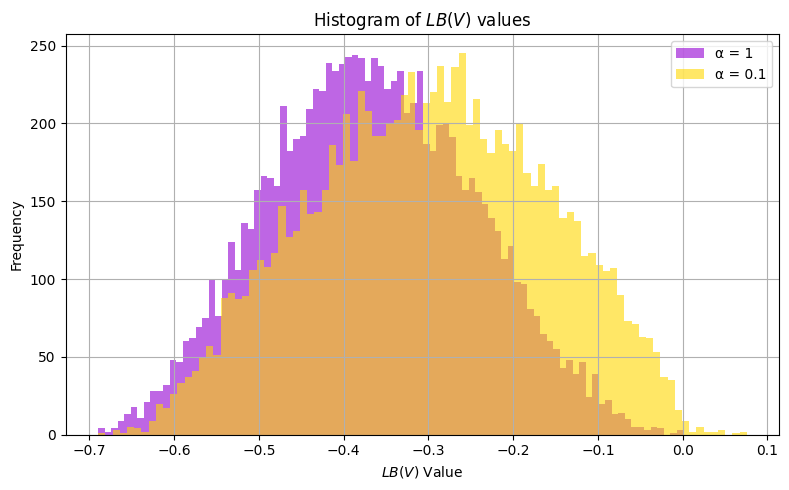

mix alpha 1 0.01%
mix alpha 0.1 0.25%


In [44]:
plt.figure(figsize=(8, 5))
plt.hist(C, bins=90, alpha=0.6, label='\u03B1 = 1', color='darkviolet')
plt.hist(B_gir_1, bins=90, alpha=0.6, label='\u03B1 = 0.1', color='gold')
plt.xlabel('$LB(V)$ Value')
plt.ylabel('Frequency')
plt.title('Histogram of $LB(V)$ values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print("mix alpha 1",f"{100 * sum(1 for x in C if x > 0) / len(C):.2f}%")
print("mix alpha 0.1",f"{100 * sum(1 for x in B_gir_1 if x > 0) / len(B_gir_2):.2f}%")

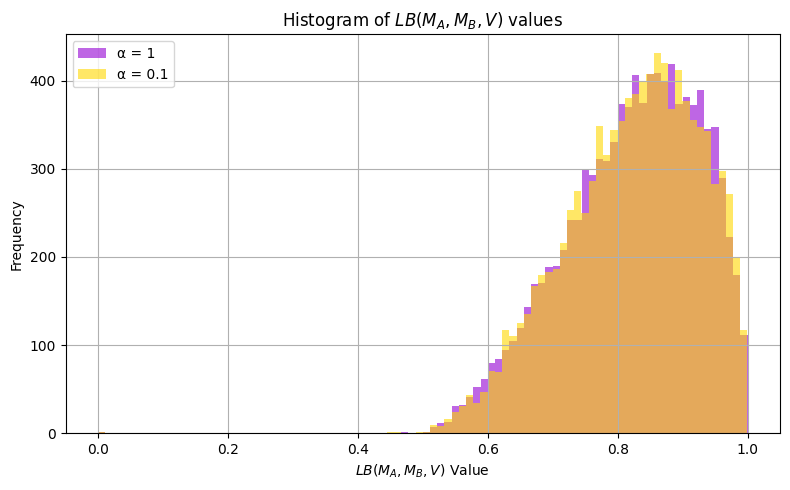

mix alpha 1 99.99%
mix alpha 0.1 4.51%


In [38]:
plt.figure(figsize=(8, 5))
plt.hist(C, bins=90, alpha=0.6, label='\u03B1 = 1', color='darkviolet')
plt.hist(purity_AB, bins=90, alpha=0.6, label='\u03B1 = 0.1', color='gold')
plt.xlabel('$LB(M_A,M_B,V)$ Value')
plt.ylabel('Frequency')
plt.title('Histogram of $LB(M_A,M_B,V)$ values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print("mix alpha 1",f"{100 * sum(1 for x in C if x > 0) / len(C):.2f}%")
print("mix alpha 0.1",f"{100 * sum(1 for x in B_gir_1 if x > 0) / len(B_gir_2):.2f}%")

# full new

In [15]:
n = 10000
num_qubits = 3

Z = qt.sigmaz() 
X = qt.sigmax() 
Y = qt.sigmay() 
I_2 = qt.qeye(2)

V = (1/2)*(qt.tensor(Z, Z) + qt.tensor(X, X) + qt.tensor(Y, Y) + qt.tensor(I_2, I_2))
V_2 = (1/2)*(qt.tensor(Z, Z, Z, Z) + qt.tensor(X, X,X,X) + qt.tensor(Y, Y,Y,Y) + qt.tensor(I_2, I_2, I_2,I_2))
V_base_norm = np.max(np.abs(V.eigenenergies()))
Z_2 = qt.tensor(Z, Z)
Z_full = qt.tensor(Z, Z, Z)
Z_norm =  np.max(np.abs(Z.eigenenergies()))


B_tot = np.zeros(n)

purity_AB = np.zeros(n)
I = np.zeros(n)

K = np.zeros(n)


for i in range(1,n):
    random_state_1 = create_random_state(num_qubits)
    random_state_2 = create_random_state(num_qubits)

    p_random_1 = compute_density_matrix(random_state_1)
    p_random_2 = compute_density_matrix(random_state_2)
    u = np.random.uniform(0, 1)
    P_1, P_2= np.random.dirichlet([0.1, 0.1])
    

    p_mixed = (P_1*p_random_1 + P_2*p_random_2) 
    #p_mixed = p_random_1

    p_A, p_B, p_C, p_AB, p_AC, p_BC = compute_reduced_density_matrices_3(p_mixed)

    #------------------------------------------Provo a tenere stati interessanti per cui non ho bound--------------------------------------------#

    avg_Z_A = (p_A * Z).tr()
    avg_Z_B = (p_B * Z).tr()
    avg_Z_C = (p_C * Z).tr()
    avg_Z_AC = (p_AC * Z_2).tr()
    avg_Z_BC = (p_BC * Z_2).tr()
    avg_Z_AB = (p_AB * Z_2).tr()
    avg_Z_full = (p_mixed * Z_full).tr()
    Var_C = (p_C * (Z**2)).tr() - ((p_C * Z).tr())**2


    # Compute Tr[V * rho_AB]
    Tr_V_rhoAB = (V * p_AB).tr()

    # Compute Tr[V * (rho_A ⊗ rho_B)]
    rho_A_tensor_B = qt.tensor(p_A, p_B)
    Tr_V_rhoA_rhoB = (V * rho_A_tensor_B).tr()

    rho_A_tensor_A = qt.tensor(p_A, p_A)
    Tr_V_rhoA_rhoA = (V @ rho_A_tensor_A).tr()


    purity_AB[i] = (p_AB @ p_AB).tr()


    A = np.sqrt(0.5*(purity_AB[i] - 1/2)).real
    Bound_gir_ab = (1/2 - A)*np.log(1/2 - A) + (1/2 + A)*np.log(1/2 + A)
    k = find_k(purity_AB[i])
    K[i] = k
    if k > 1:
        alpha = 1/k - np.sqrt((1-1/k)*(purity_AB[i]-1/k))
        l1 = (1 - alpha)/(k-1)
        lk = alpha

        B_tot = (Bound_gir_ab + (lk-1)*np.log(l1) - lk*np.log(lk)).real
    else:
        alpha = 1/k - np.sqrt((1-1/k)*(purity_AB[i]-1/k))
        lk = alpha

        B_tot = (Bound_gir_ab  - lk*np.log(lk)  ).real  



    I[i] = qt.entropy_vn(p_AC, base = 2) + qt.entropy_vn(p_BC, base = 2) - qt.entropy_vn(p_mixed, base = 2) - qt.entropy_vn(p_C, base = 2)
    



C:\Users\Francois\AppData\Local\Temp\ipykernel_7572\922586664.py:66: RuntimeWarning: invalid value encountered in sqrt
  A = np.sqrt(0.5*(purity_AB[i] - 1/2)).real
C:\Users\Francois\AppData\Local\Temp\ipykernel_7572\922586664.py:71: RuntimeWarning: invalid value encountered in sqrt
  alpha = 1/k - np.sqrt((1-1/k)*(purity_AB[i]-1/k))


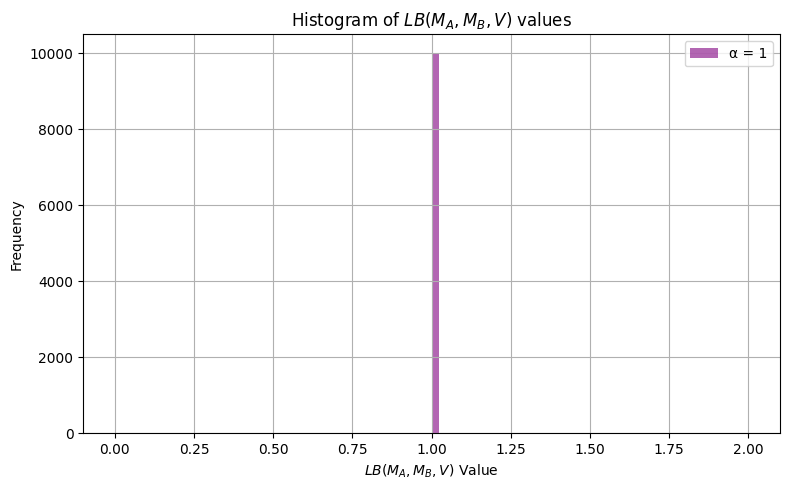

TypeError: 'numpy.float64' object is not iterable

In [16]:
plt.figure(figsize=(8, 5))
plt.hist(K, bins=90, alpha=0.6, label='\u03B1 = 1', color='purple')
plt.xlabel('$LB(M_A,M_B,V)$ Value')
plt.ylabel('Frequency')
plt.title('Histogram of $LB(M_A,M_B,V)$ values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print("me+gir",f"{100 * sum(1 for x in B_tot if x > 0) / len(B_gir_1):.2f}%")

# iter check 1

In [76]:
n = 10000
B_gir_1_max_1 = np.zeros(n)
B_gir_2_max_1 = np.zeros(n)


In [77]:
B_gir_1_max_01 = np.zeros(n)
B_gir_2_max_01 = np.zeros(n)

In [79]:
l = 5
per_cont_pureV_1 = np.zeros(l)
per_cont_pureV_01 = np.zeros(l)
per_cont_mix_1 = np.zeros(l)
per_cont_mix_01 = np.zeros(l)

In [81]:


num_qubits = 3

Z = qt.sigmaz() 
X = qt.sigmax() 
Y = qt.sigmay() 
I_2 = qt.qeye(2)

V = (1/2)*(qt.tensor(Z, Z) + qt.tensor(X, X) + qt.tensor(Y, Y) + qt.tensor(I_2, I_2))
V_2 = (1/2)*(qt.tensor(Z, Z, Z, Z) + qt.tensor(X, X,X,X) + qt.tensor(Y, Y,Y,Y) + qt.tensor(I_2, I_2, I_2,I_2))
V_base_norm = np.max(np.abs(V_A.eigenenergies()))
Z_2 = qt.tensor(Z, Z)
Z_full = qt.tensor(Z, Z, Z)
Z_norm =  np.max(np.abs(Z.eigenenergies()))


B_gir_1 = np.zeros(n)
B_gir_2 = np.zeros(n)
purity_AB = np.zeros(n)
I = np.zeros(n)

for j in range(0,l):

    for i in range(1,n):
        random_state_1 = create_random_state(num_qubits)
        random_state_2 = create_random_state(num_qubits)

        p_random_1 = compute_density_matrix(random_state_1)
        p_random_2 = compute_density_matrix(random_state_2)
        u = np.random.uniform(0, 1)
        P_1, P_2= np.random.dirichlet([1, 1])
        

        p_mixed = (P_1*p_random_1 + P_2*p_random_2) 
        #p_mixed = p_random_1

        p_A, p_B, p_C, p_AB, p_AC, p_BC = compute_reduced_density_matrices_3(p_mixed)

        #------------------------------------------Provo a tenere stati interessanti per cui non ho bound--------------------------------------------#

        avg_Z_A = (p_A * Z).tr()
        avg_Z_B = (p_B * Z).tr()
        avg_Z_C = (p_C * Z).tr()
        avg_Z_AC = (p_AC * Z_2).tr()
        avg_Z_BC = (p_BC * Z_2).tr()
        avg_Z_AB = (p_AB * Z_2).tr()
        avg_Z_full = (p_mixed * Z_full).tr()
        Var_C = (p_C * (Z**2)).tr() - ((p_C * Z).tr())**2


        # Compute Tr[V * rho_AB]
        Tr_V_rhoAB = (V * p_AB).tr()

        # Compute Tr[V * (rho_A ⊗ rho_B)]
        rho_A_tensor_B = qt.tensor(p_A, p_B)
        Tr_V_rhoA_rhoB = (V * rho_A_tensor_B).tr()

        rho_A_tensor_A = qt.tensor(p_A, p_A)
        Tr_V_rhoA_rhoA = (V @ rho_A_tensor_A).tr()


        purity_AB[i] = (p_AB @ p_AB).tr()


        A = np.sqrt(0.5*(purity_AB[i] - 1/2)).real
        Bound_gir_ab = (1/2 - A)*np.log(1/2 - A) + (1/2 + A)*np.log(1/2 + A)

        B_gir_2[i] = (    ((avg_Z_AB-avg_Z_A*avg_Z_B)**2)/(2*Z_norm**4)  + Bound_gir_ab ).real
        B_gir_1[i] = (    ((Tr_V_rhoAB-Tr_V_rhoA_rhoB)**2)/(2*V_base_norm**2)   + Bound_gir_ab ).real

    
    per_cont_pureV_1[j] = 100 * sum(1 for x in B_gir_1 if x > 0) / len(B_gir_1)
    per_cont_mix_1[j] = 100 * sum(1 for x in B_gir_2 if x > 0) / len(B_gir_2)

    
    if per_cont_mix_1[j] > np.max(np.delete(per_cont_mix_1, j)):
        B_gir_1_max_1 = B_gir_1
        B_gir_2_max_1 = B_gir_2


C:\Users\Francois\AppData\Local\Temp\ipykernel_7572\3436476002.py:64: RuntimeWarning: invalid value encountered in sqrt
  A = np.sqrt(0.5*(purity_AB[i] - 1/2)).real


KeyboardInterrupt: 

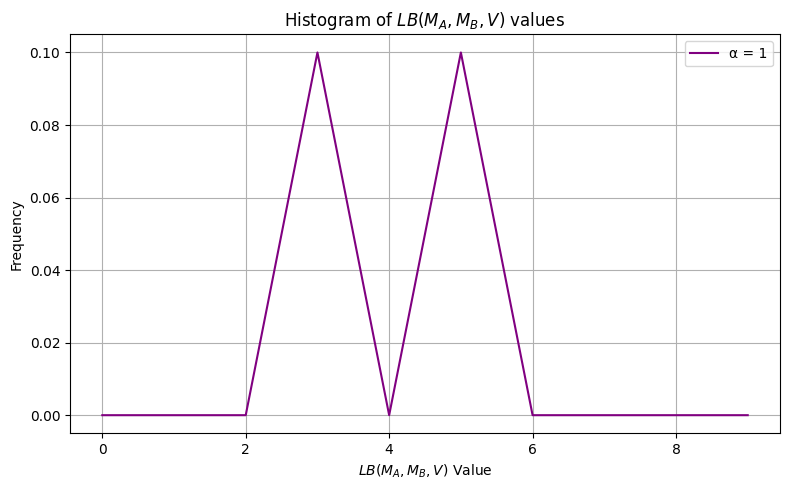

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(per_cont_pureV_1, label='\u03B1 = 1', color='purple')
plt.xlabel('$LB(M_A,M_B,V)$ Value')
plt.ylabel('Frequency')
plt.title('Histogram of $LB(M_A,M_B,V)$ values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


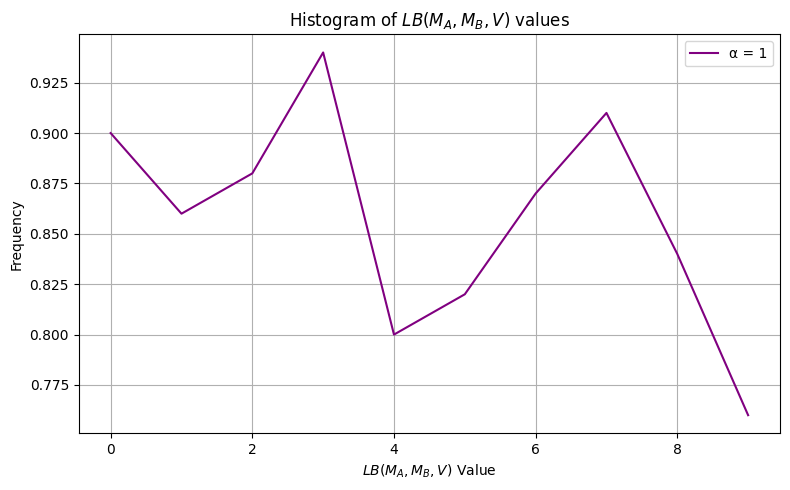

In [ ]:
plt.figure(figsize=(8, 5))
plt.plot(per_cont_mix_1, label='\u03B1 = 1', color='purple')
plt.xlabel('$LB(M_A,M_B,V)$ Value')
plt.ylabel('Frequency')
plt.title('Histogram of $LB(M_A,M_B,V)$ values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# iter chack 0.1

In [82]:

num_qubits = 3

Z = qt.sigmaz() 
X = qt.sigmax() 
Y = qt.sigmay() 
I_2 = qt.qeye(2)

V = (1/2)*(qt.tensor(Z, Z) + qt.tensor(X, X) + qt.tensor(Y, Y) + qt.tensor(I_2, I_2))
V_2 = (1/2)*(qt.tensor(Z, Z, Z, Z) + qt.tensor(X, X,X,X) + qt.tensor(Y, Y,Y,Y) + qt.tensor(I_2, I_2, I_2,I_2))
V_base_norm = np.max(np.abs(V_A.eigenenergies()))
Z_2 = qt.tensor(Z, Z)
Z_full = qt.tensor(Z, Z, Z)
Z_norm =  np.max(np.abs(Z.eigenenergies()))


B_gir_1 = np.zeros(n)
B_gir_2 = np.zeros(n)
purity_AB = np.zeros(n)
I = np.zeros(n)

for j in range(0,l):

    for i in range(1,n):
        random_state_1 = create_random_state(num_qubits)
        random_state_2 = create_random_state(num_qubits)

        p_random_1 = compute_density_matrix(random_state_1)
        p_random_2 = compute_density_matrix(random_state_2)
        u = np.random.uniform(0, 1)
        P_1, P_2= np.random.dirichlet([0.1, 0.1])
        

        p_mixed = (P_1*p_random_1 + P_2*p_random_2) 
        #p_mixed = p_random_1

        p_A, p_B, p_C, p_AB, p_AC, p_BC = compute_reduced_density_matrices_3(p_mixed)

        #------------------------------------------Provo a tenere stati interessanti per cui non ho bound--------------------------------------------#

        avg_Z_A = (p_A * Z).tr()
        avg_Z_B = (p_B * Z).tr()
        avg_Z_C = (p_C * Z).tr()
        avg_Z_AC = (p_AC * Z_2).tr()
        avg_Z_BC = (p_BC * Z_2).tr()
        avg_Z_AB = (p_AB * Z_2).tr()
        avg_Z_full = (p_mixed * Z_full).tr()
        Var_C = (p_C * (Z**2)).tr() - ((p_C * Z).tr())**2


        # Compute Tr[V * rho_AB]
        Tr_V_rhoAB = (V * p_AB).tr()

        # Compute Tr[V * (rho_A ⊗ rho_B)]
        rho_A_tensor_B = qt.tensor(p_A, p_B)
        Tr_V_rhoA_rhoB = (V * rho_A_tensor_B).tr()

        rho_A_tensor_A = qt.tensor(p_A, p_A)
        Tr_V_rhoA_rhoA = (V @ rho_A_tensor_A).tr()


        purity_AB[i] = (p_AB @ p_AB).tr()


        A = np.sqrt(0.5*(purity_AB[i] - 1/2)).real
        Bound_gir_ab = (1/2 - A)*np.log(1/2 - A) + (1/2 + A)*np.log(1/2 + A)

        B_gir_2[i] = (    ((avg_Z_AB-avg_Z_A*avg_Z_B)**2)/(2*Z_norm**4)  + Bound_gir_ab ).real
        B_gir_1[i] = (    ((Tr_V_rhoAB-Tr_V_rhoA_rhoB)**2)/(2*V_base_norm**2)   + Bound_gir_ab ).real

    
    per_cont_pureV_01[j] = 100 * sum(1 for x in B_gir_1 if x > 0) / len(B_gir_1)
    per_cont_mix_01[j] = 100 * sum(1 for x in B_gir_2 if x > 0) / len(B_gir_2)

    if per_cont_mix_01[j] > np.max(np.delete(per_cont_mix_01, j)):
        B_gir_1_max_01 = B_gir_1
        B_gir_2_max_01 = B_gir_2


KeyboardInterrupt: 

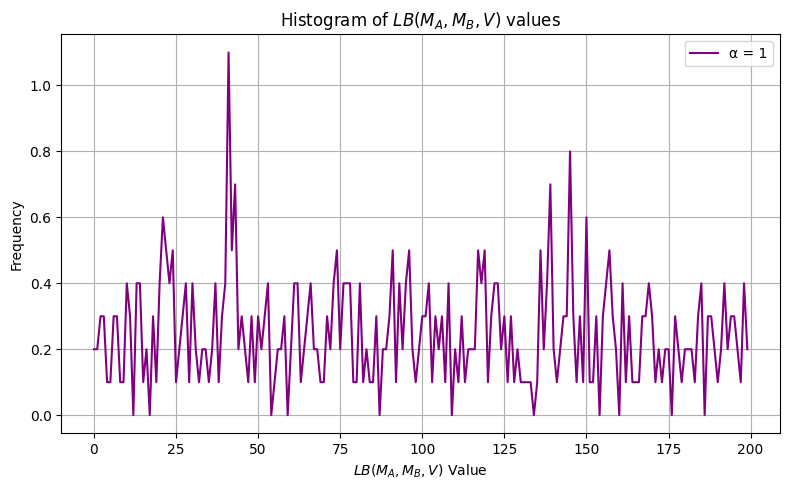

In [62]:
plt.figure(figsize=(8, 5))
plt.plot(per_cont_pureV_01, label='\u03B1 = 1', color='purple')
plt.xlabel('$LB(M_A,M_B,V)$ Value')
plt.ylabel('Frequency')
plt.title('Histogram of $LB(M_A,M_B,V)$ values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

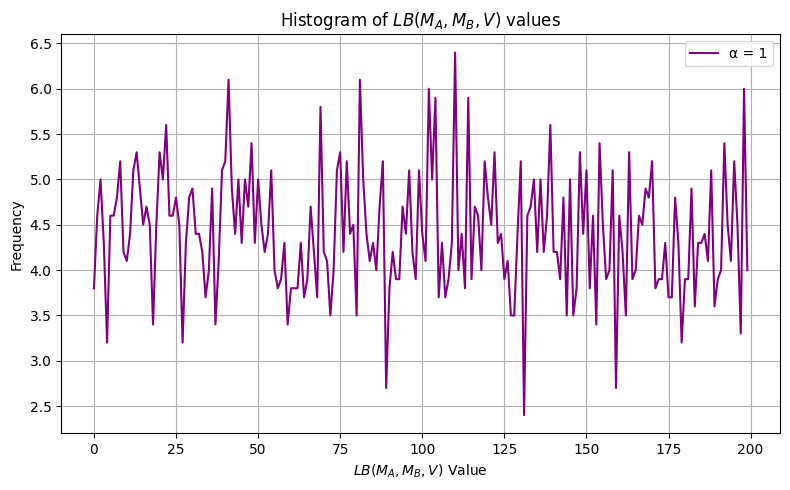

In [63]:
plt.figure(figsize=(8, 5))
plt.plot(per_cont_mix_01, label='\u03B1 = 1', color='purple')
plt.xlabel('$LB(M_A,M_B,V)$ Value')
plt.ylabel('Frequency')
plt.title('Histogram of $LB(M_A,M_B,V)$ values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [64]:
print("Maxes: alpha = 1, full V", np.max(per_cont_pureV_1),"\n")
print("Maxes: alpha = 1, mix", np.max(per_cont_mix_1),"\n")
print("Maxes: alpha = 0.1, full V", np.max(per_cont_pureV_01),"\n")
print("Maxes: alpha = 0.1, mix", np.max(per_cont_mix_01),"\n")

Maxes: alpha = 1, full V 0.2 

Maxes: alpha = 1, mix 1.6 

Maxes: alpha = 0.1, full V 1.1 

Maxes: alpha = 0.1, mix 6.4 



# Maxes plots

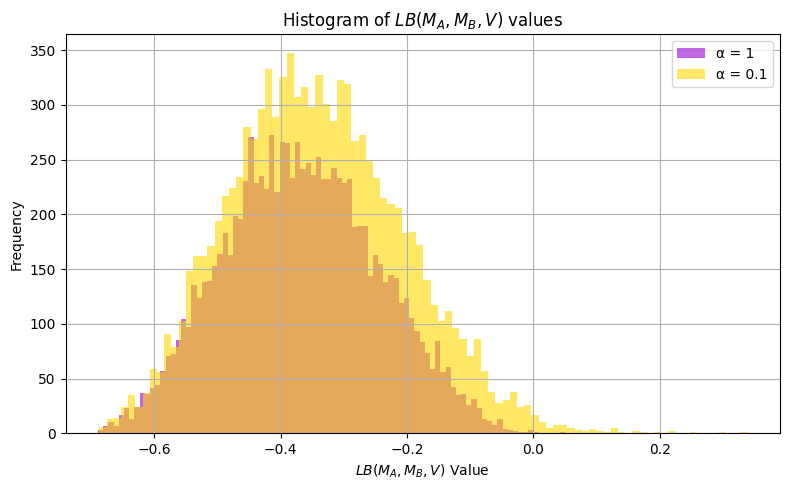

mix alpha 1 0.02%
mix alpha 0.1 7.60%


In [ ]:
plt.figure(figsize=(8, 5))
plt.hist(B_gir_1_max_1, bins=90, alpha=0.6, label='\u03B1 = 1', color='darkviolet')
plt.hist(B_gir_1_max_01, bins=90, alpha=0.6, label='\u03B1 = 0.1', color='gold')
plt.xlabel('$LB(M_A,M_B,V)$ Value')
plt.ylabel('Frequency')
plt.title('Histogram of $LB(M_A,M_B,V)$ values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print("mix alpha 1",f"{100 * sum(1 for x in B_gir_1_max_1 if x > 0) / len(C):.2f}%")
print("mix alpha 0.1",f"{100 * sum(1 for x in B_gir_2_max_1 if x > 0) / len(B_gir_2):.2f}%")

In [ ]:
plt.figure(figsize=(8, 5))
plt.hist(B_gir_2_max_1, bins=90, alpha=0.6, label='\u03B1 = 1', color='darkviolet')
plt.hist(B_gir_2_max_01, bins=90, alpha=0.6, label='\u03B1 = 0.1', color='gold')
plt.xlabel('$LB(M_A,M_B,V)$ Value')
plt.ylabel('Frequency')
plt.title('Histogram of $LB(M_A,M_B,V)$ values')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
print("mix alpha 1",f"{100 * sum(1 for x in B_gir_1_max_1 if x > 0) / len(C):.2f}%")
print("mix alpha 0.1",f"{100 * sum(1 for x in B_gir_2_max_1 if x > 0) / len(B_gir_2):.2f}%")